# Project 2

This project is my first attempt at building a model to make predictions for a kaggle competition. This project will follow the general data science process, as we go through each step it will be labeled in the notebook below.

# Step 1: Define the Problem

The website Zillow wants to create a "market value" tool that will allow customers using their site to see an estimated price for any home they list on the site. This tool should be able to generalize to all houses within the city of Ames, Iowa. 

# Step 2: Gather data

Data was provided for this project, in the form of a .csv file. The csv file contained information on approximately 2,000 houses that were sold between 2005 and 2010 in Ames, with 80 features given for each sale.

# Step 3: Exploratory Data Analysis

Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [144]:
# Read in original data and save it to houses. Make a copy df that will be manipulated
houses = pd.read_csv('../Data/train.csv')
df = houses

# Read in test data and save it to houses_holdout. Make a copy test_data that will be manipulated
houses_holdout = pd.read_csv('../Data/test.csv')
test_data = houses_holdout

In [194]:
null_cols = df.isnull().sum()[df.isnull().sum() > 0]
null_cols = null_cols/2051
null_cols.sort_values(ascending=True, inplace=True)

test_nulls = test_data.isnull().sum()[test_data.isnull().sum() > 0]
test_nulls = test_nulls/879
test_nulls.sort_values(ascending=True, inplace=True)

In [195]:
test_nulls = test_nulls.reindex(null_cols.index)

In [196]:
test_nulls.fillna(0, inplace=True)

In [197]:
len(null_cols), len(test_nulls)

(26, 26)

In [205]:
null_cols_high = null_cols[null_cols > .1]
test_nulls_high = test_nulls[test_nulls > .1]

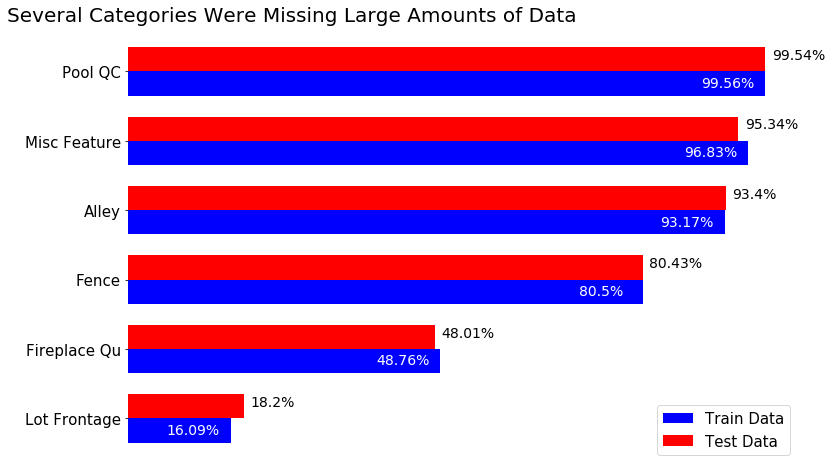

In [243]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

ind = np.arange(len(null_cols_high))
width = 0.35

g1 = ax.barh(ind, null_cols_high, width, color='b')
g2 = ax.barh(ind + width, test_nulls_high, width, color='r')

ax.set_title('Several Categories Were Missing Large Amounts of Data', position=(-.18,1), ha='left', size=20)
ax.set_xlabel('Null Observations (% of total)')

ax.set_yticks(ind + width/2)
ax.set_yticklabels(test_nulls_high.index, size=15)

# ax.text(x data + .01, i, label, color, size)
for i in range(len(null_cols_high)):
    ax.text(null_cols_high[i]-.1, i-.05, str(round(null_cols_high[i]*100,2)) + '%', size = 14, color = 'w')
    ax.text(test_nulls_high[i]+.01, i+width, str(round(test_nulls_high[i]*100,2)) + '%', size = 14)

ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
    
ax.legend((g1[0], g2[0]), ('Train Data', 'Test Data'), fontsize=15)
ax.autoscale_view()

In [158]:
# Find number of rows and columns using df.shape
df.shape, test_data.shape

((2051, 81), (879, 80))

This data set has 2,051 rows, and 81 columns. Each row represents one house that was sold, while each column represents one feature, or one piece of information about the specific house that was sold

In [ ]:
# Investigate first 5 rows using df.head()
df.head()

Each row has an absolutely massive amount of information. Before moving forward, we need to determine what the data type of each column is, and how many null values are present in each column

In [ ]:
df.info()

There are a total of 11 columns stored as floats, 28 stored as integers, and 42 stored as objects. Before doing any modeling, all data that will be used in the model must be changed to numeric

In [ ]:
df.describe()

Basic info for numeric columns

Investigate number of null values

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

There are multiple columns with many null values in both data sets. These columns will not have significant use, and should not be considered when making our model.
- Pool QC
- Alley
- Fence

In [ ]:
df.drop(['Pool QC', 'Alley', 'Fence'], axis=1, inplace=True)
test_data.drop(['Pool QC', 'Alley', 'Fence'], axis=1, inplace=True)

## Data Cleaning

In [ ]:
# Create function to find columns that contain a specific string
def col_finder(df, conditional_str):
    cols = [col for col in df.columns if conditional_str in col]
    return cols

In [ ]:
def null_filler(df, col, value):
    df[col] = df[col].fillna(value)
    return None

Preprocessing

In [ ]:
rating_dict = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, 'NA':0}

# Find all columns that use the rating system Ex, Gd, TA, Fa, Po
rating_cols = [col for col in df.columns if df[col].sort_values().iloc[0] == 'Ex']

# Remap using the dictionary created above
for col in rating_cols:
    df[col] = df[col].fillna('NA')
    df[col] = df[col].map(rating_dict)
    test_data[col] = test_data[col].fillna('NA')
    test_data[col] = test_data[col].map(rating_dict)

In [ ]:
yes_no_dict = {'Y':1, 'N':0}

# Remap using the dictionary created above
df['Central Air'] = df['Central Air'].map(yes_no_dict)

test_data['Central Air'] = test_data['Central Air'].map(yes_no_dict)

In [ ]:
# # This cell will create a dictionary to map values of categorical variables with fewer than 20 obesrvations to
# # 'Other' so that I have fewer columns when creating dummy varaibles with pd.get_dummies

# # sub_20_values = []
# # sub_20_cols = []
# # other_dict = {}
# # obj_cols = [col for col in df.columns if df[col].dtype == 'object']
# # for col in obj_cols:
# #     for value in df[col].unique():
# #         if type(value) == float:
# #             continue
# #         if df[col].value_counts()[value] < 20:
# #             sub_20_values.append([col, value, df[col].value_counts()[value]])
# #             sub_20_cols.append(col)
# #             if other_dict.get(col):
# #                 other_dict[col][value] = 'Other'
# #             else:
# #                 other_dict[col] = {value: 'Other'}
            

# len(sub_20_values)

# other_dict

# sub_20_cols = list(set(sub_20_cols))

In [ ]:
dummies = ['Misc Feature', 'Garage Finish', 'Garage Type', 'Bldg Type', 'BsmtFin Type 1', 'BsmtFin Type 2',
           'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'House Style', 'Land Contour', 'Land Slope',
           'Lot Config', 'Lot Shape', 'Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Neighborhood',
           'Roof Matl', 'Roof Style', 'Street', 'Utilities', 'Condition 1', 'Condition 2', 'Bsmt Exposure',
           'Electrical', 'Functional', 'Paved Drive', 'Sale Type', 'Mo Sold', 'Yr Sold']

In [ ]:
for col in dummies:
    df[col] = df[col].fillna('NA')
    test_data[col] = test_data[col].fillna('NA')
    train_vals = sorted(df[col].unique().tolist())
    test_vals = sorted(test_data[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    df[col] = pd.Categorical(df[col], categories=total_vals)
    test_data[col] = pd.Categorical(test_data[col], categories=total_vals)

In [ ]:
df = pd.get_dummies(df, columns=dummies, drop_first=True)

In [ ]:
df.info()

In [ ]:
test_data = pd.get_dummies(test_data, columns=dummies, drop_first=True)

In [ ]:
test_data.info()

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
# Find which other columns are null for the one observation of null in BsmtFin SF 1
df[df['BsmtFin SF 1'].isnull()].isnull().sum()[df[df['BsmtFin SF 1'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

This one row is missing most of the information for the basement. None of these columns also contain missing data in the test set, so these features do not require cleaning across all data. Because there is no way to infer the missing information from the given information, I will drop this observation from the dataset.

In [ ]:
df.drop(labels=df[df['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [ ]:
df.shape

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
df[df['Bsmt Full Bath'].isnull()].isnull().sum()[df[df['Bsmt Full Bath'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Drop this observation again with same rationale as above

In [ ]:
df.drop(labels = df[df['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
mas_cols = col_finder(df, 'Mas')
mas_cols

In [ ]:
NA_dummy_cols = col_finder(df, 'NA')
NA_dummy_cols

In [ ]:
df[NA_dummy_cols].sum()

In [ ]:
df[df['Mas Vnr Area'].isnull()][mas_cols]

In [ ]:
test_data[test_data['Mas Vnr Area'].isnull()][mas_cols]

All observations with null values for masonry also have null values for the masonry type. This implies that these houses do not have masonry. Therefore I will replace all null Mas Vnr Area values with 0

In [ ]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
test_data['Mas Vnr Area'] = test_data['Mas Vnr Area'].fillna(0)

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

In [ ]:
df[df['Garage Cars'].isnull()].isnull().sum().sort_values(ascending=False)

In [ ]:
df[df['Garage Area'] == 0][col_finder(df,'Garage')].sum()

In [ ]:
test_data[test_data['Garage Yr Blt'].isnull()][col_finder(test_data, 'Garage')].sum()

In the training data, all garages that have 0 area have 0 cars and have null values for the garage year built. This implies that the houses in these observations do not have garages. 

However, in the testing data there is one observation, index 765, where there is a garage with the house. This means that I have to replace the value for Garage Yr Blt for index 765 in the test data with a meaningful value. Since this value is impossible to know, there are a couple of options.
1. Use the year the house was built
2. Use the year of the last remodel on that house
3. The average value for Garage Yr Built from training data

In [ ]:
sns.distplot(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()])

In [ ]:
garage_cols = col_finder(test_data, 'Garage')

In [ ]:
test_data.loc[765, garage_cols]

In [ ]:
df[df['Garage Area'].isnull()]

In [ ]:
df.loc[1712, garage_cols]

I know that this house has a detached garage, but the information on when it was built and the size of the garage are both missing. Because it is only 1 observation, I will fill in the missing values with mean estimates for all three categories.

In [ ]:
df.loc[1712, ['Garage Yr Blt', 'Garage Cars', 'Garage Area']] = [df['Garage Yr Blt'].mean(), df['Garage Cars'].mean(), df['Garage Area'].mean()]

In [47]:
df.loc[1712, garage_cols]

Garage Yr Blt          1978.734884
Garage Cars               1.776855
Garage Area             473.692871
Garage Qual               0.000000
Garage Cond               0.000000
Garage Finish_RFn         0.000000
Garage Finish_NA          1.000000
Garage Finish_Unf         0.000000
Garage Type_BuiltIn       0.000000
Garage Type_CarPort       0.000000
Garage Type_Detchd        1.000000
Garage Type_2Types        0.000000
Garage Type_Basment       0.000000
Garage Type_NA            0.000000
Name: 1712, dtype: float64

In [48]:
min(df['Garage Yr Blt'].tolist())

1895.0

In [49]:
df['Garage Yr Blt'].mean()

1978.7348837209302

In [50]:
test_data.loc[765, 'Garage Yr Blt'] = df['Garage Yr Blt'].mean()

In [51]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(1895)
test_data['Garage Yr Blt'] = test_data['Garage Yr Blt'].fillna(1895)

Check for what null values remain in both data sets

In [52]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    330
dtype: int64

In [53]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    160
dtype: int64

#### Predict Lot Frontage Values for missing info

In [54]:
target = 'Lot Frontage'
features = [col for col in df.columns if col != 'SalePrice' and col != target]

In [55]:
lot_holdout = df[df['Lot Frontage'].isnull()][features]
X_lot = df[df['Lot Frontage'].isnull() == False][features]
y_lot = df[df['Lot Frontage'].isnull() == False][target]

In [56]:
X_lot_train, X_lot_test, y_lot_train, y_lot_test = train_test_split(X_lot, y_lot, random_state=42, test_size=0.2)

ss_lot = StandardScaler()
X_lot_train_scaled = ss_lot.fit_transform(X_lot_train)
X_lot_test_scaled = ss_lot.transform(X_lot_test)

In [57]:
alpha = np.logspace(1, 5, num=100)
ridge_lot = RidgeCV(alphas = alpha)

ridge_lot_scores = cross_val_score(ridge_lot, X_lot_train_scaled, y_lot_train, cv=5)
print('Ridge cross-val scores:', ridge_lot_scores)
print('Average ridgeCV scores:', ridge_lot_scores.mean())

Ridge cross-val scores: [0.64157052 0.6124622  0.62550219 0.43986474 0.28934751]
Average ridgeCV scores: 0.5217494326090591


In [59]:
lasso_lot = LassoCV(cv=10, verbose=1, max_iter=2000)

lasso_scores = cross_val_score(lasso_lot, X_lot_train_scaled, y_lot_train, cv=5)
print('Lasso cross-val scores:', lasso_scores)
print('Average LassoCV scores:', lasso_scores.mean())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso cross-val scores: [0.67259714 0.6563427  0.57505072 0.46215555 0.10573081]
Average LassoCV scores: 0.49437538341694454


.......................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished


In [60]:
lasso_lot.fit(X_lot_train_scaled, y_lot_train)
lasso_lot.score(X_lot_test_scaled, y_lot_test)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.519067223510688

In [61]:
ridge_lot.fit(X_lot_train_scaled, y_lot_train)
ridge_lot.score(X_lot_test_scaled, y_lot_test)

0.5308315602413037

Because the RidgeCV R2 scores are better, I'm going to use this rather than the mean

In [62]:
lot_holdout_scaled = ss_lot.transform(lot_holdout)

In [63]:
ridge_lot_predictions = ridge_lot.predict(lot_holdout_scaled)

In [64]:
for i in df.index:
    if df['Lot Frontage'].isnull()[i]:
        df.loc[i, 'Lot Frontage'] = ridge_lot_predictions[list(lot_holdout.index).index(i)]

In [65]:
test_lot = test_data[test_data['Lot Frontage'].isnull()][features]
test_lot_scaled = ss_lot.transform(test_lot)
ridge_holdout_predictions = ridge_lot.predict(test_lot_scaled)

for i in test_data.index:
    if test_data['Lot Frontage'].isnull()[i]:
        test_data.loc[i, 'Lot Frontage'] = ridge_holdout_predictions[list(test_lot.index).index(i)]

In [66]:
test_data.isnull().sum().sum() + df.isnull().sum().sum()

0

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Columns: 261 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(35), uint8(215)
memory usage: 1.2 MB


In [68]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Columns: 260 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(34), uint8(215)
memory usage: 493.7 KB


## Feature Engineering/Selection

Find which variables have the strongest correlation with Sale Price

In [69]:
df.corr().loc[:, 'SalePrice'].sort_values()

Garage Finish_Unf      -0.432880
Garage Type_Detchd     -0.369497
Foundation_CBlock      -0.355950
Lot Shape_Reg          -0.306793
MS Zoning_RM           -0.280822
Paved Drive_N          -0.273847
PID                    -0.255412
Roof Style_Gable       -0.249569
MS SubClass_30         -0.248744
Garage Type_NA         -0.231186
Garage Finish_NA       -0.231050
Sale Type_WD           -0.214939
Neighborhood_OldTown   -0.208550
Electrical_FuseA       -0.199537
House Style_1.5Fin     -0.195973
Exterior 1st_Wd Sdng   -0.191905
Neighborhood_NAmes     -0.189557
Neighborhood_IDOTRR    -0.189395
MS SubClass_50         -0.182494
Exterior 2nd_Wd Sdng   -0.173124
BsmtFin Type 1_NA      -0.160410
BsmtFin Type 2_NA      -0.155014
Bsmt Exposure_NA       -0.153084
BsmtFin Type 1_Rec     -0.151045
Exterior 1st_MetalSd   -0.148452
Exterior 2nd_MetalSd   -0.139465
Enclosed Porch         -0.135776
Neighborhood_Sawyer    -0.133804
Neighborhood_BrkSide   -0.132402
BsmtFin Type 1_BLQ     -0.130214
          

Find which variables have strong correlations with each other

In [70]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr = df.corr()

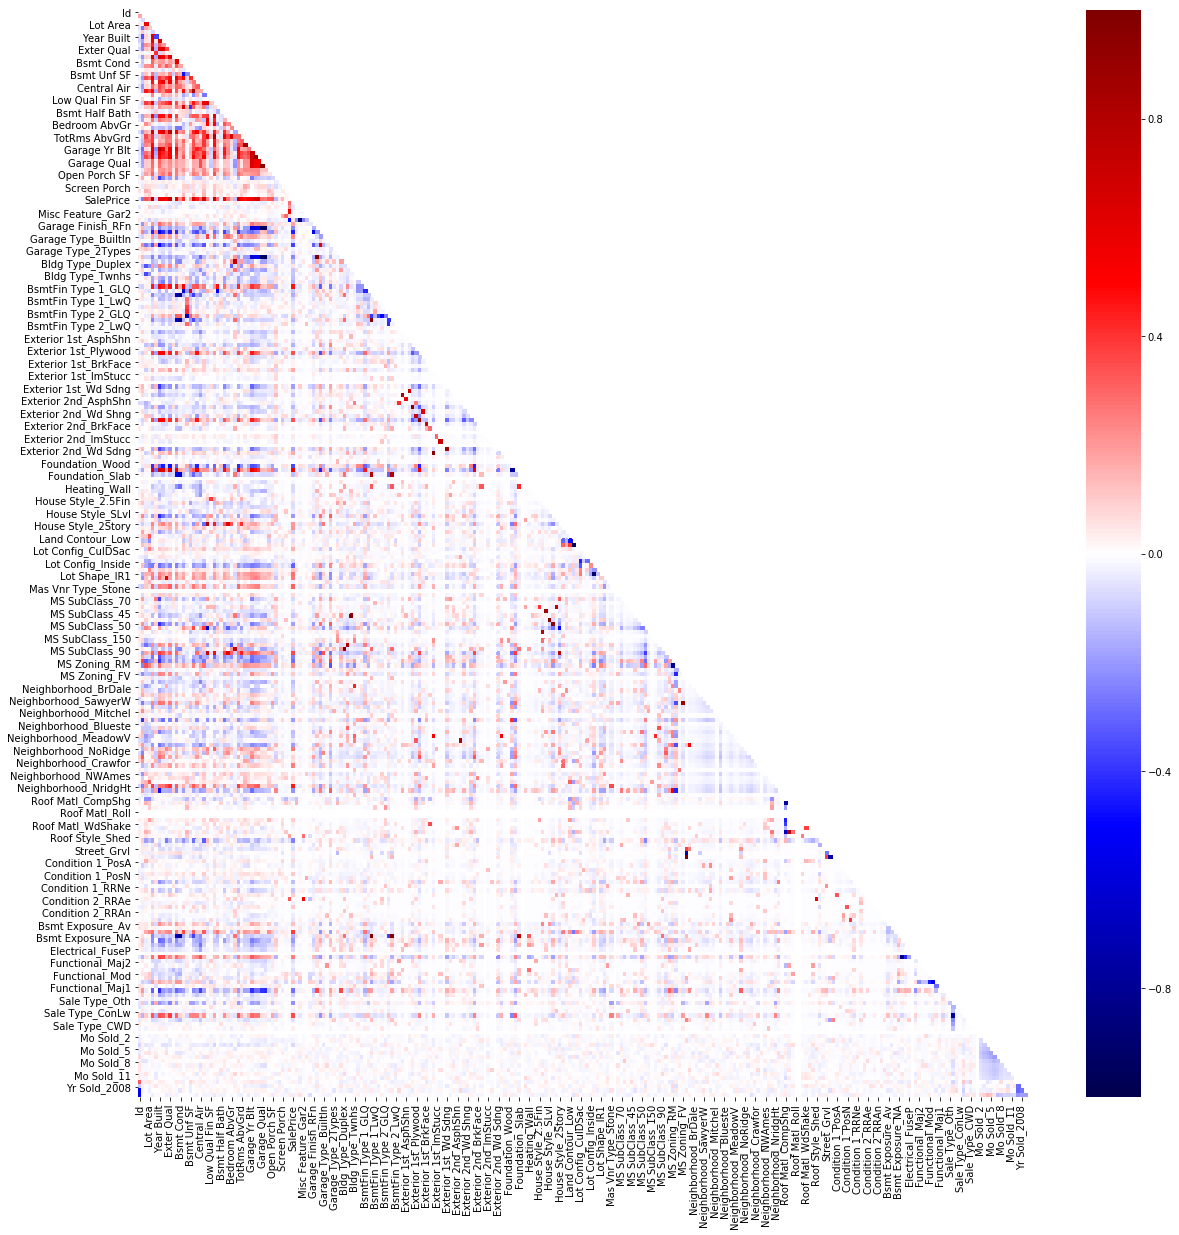

In [71]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, cmap='seismic', vmin=-1, vmax=1)

In [72]:
non_dummy_cols = [col for col in df.columns if '_' not in col]
non_dummies = df[non_dummy_cols]
non_dummies.head()

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0  109  533352170      55.65334     13517             6             8   
1  544  531379050      43.00000     11492             7             5   
2  153  535304180      68.00000      7922             5             7   
3  318  916386060      73.00000      9802             5             5   
4  255  906425045      82.00000     14235             6             8   

   Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual    ...      \
0        1976            2005         289.0           4    ...       
1        1996            1997         132.0           4    ...       
2        1953            2007           0.0           3    ...       
3        2006            2007           0.0           3    ...       
4        1900            1993           0.0           3    ...       

   Garage Qual  Garage Cond  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0            3            3             0             44               0   
1            3            3             0             74               0   
2            3            3             0             52               0   
3            3            3           100              0               0   
4            3            3             0             59               0   

   3Ssn Porch  Screen Porch  Pool Area  Misc Val  SalePrice  
0           0             0          0         0     130500  
1           0             0          0         0     220000  
2           0             0          0         0     109000  
3           0             0          0         0     174000  
4           0             0          0         0     138500  

[5 rows x 46 columns]

In [73]:
non_dummies.drop(['Id', 'PID'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [74]:
sns.pairplot(non_dummies)

Features with strong correlation with saleprice:
- `'Overall Qual'`
- `'Gr Liv Area'`
- `'Garage Area'`

In [75]:
df['Garage Yr Blt'].sort_values(ascending=False).head()

1699    2207.0
1241    2010.0
144     2010.0
1732    2009.0
1700    2009.0
Name: Garage Yr Blt, dtype: float64

In [76]:
df.loc[1699, 'Garage Yr Blt'] = 2007

In [77]:
df['Garage Yr Blt'].sort_values(ascending=False).head()

144     2010.0
1241    2010.0
963     2009.0
1060    2009.0
398     2009.0
Name: Garage Yr Blt, dtype: float64

In [78]:
df.loc[1699, 'Garage Yr Blt']

2007.0

# Step 4: Create Model

## Model 1: Overall Quality, Gr Liv Area, Garage Area

In [ ]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area']

In [ ]:
X = df[features]
y = df['SalePrice']

```X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)```

```lr = LinearRegression()```

```kf = KFold(n_splits = 5, shuffle=True, random_state=8)```

```scores = cross_val_score(lr, X_train, y_train, cv=kf)```

```print(scores)```

``print(scores.mean())``

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf)
print(scores)
print(scores.mean())

In [ ]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
X_holdout = test_data[features]
predictions = lr.predict(X_holdout)

In [ ]:
submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

## Model 2 - Model 1 + neighborhood dummies

In [ ]:
df.shape

In [ ]:
houses = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)

In [ ]:
houses.shape

In [ ]:
neighborhoods = df['Neighborhood'].unique().tolist()

In [ ]:
neighborhoods

In [ ]:
avg_sale = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].mean() for i in range(0, len(neighborhoods))]
nei_var = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].std() for i in range(0, len(neighborhoods))]
for i in range(len(avg_sale)):
    print(neighborhoods[i], avg_sale[i])
    print(neighborhoods[i], nei_var[i])

In [ ]:
dummies = [col for col in houses.columns if 'Neighborhood' in col]
type(dummies)

In [ ]:
features_2 = features

In [ ]:
features_2.extend(dummies)

In [ ]:
features_2

In [ ]:
X_2 = houses[features_2]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=8)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf) 
print(scores) 
print(scores.mean())

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
test_data_copy = test_data

In [ ]:
test_data.shape

In [ ]:
test_data_copy.shape

In [ ]:
test_data_copy['Neighborhood'] = test_data_copy['Neighborhood'].map(lambda cell: 
                                            'Other' if cell in ['Blueste', 'Greens', 'GrnHill', 'Landmrk'] else cell)

In [ ]:
test_data_copy.shape

In [ ]:
test_data_copy = pd.get_dummies(test_data_copy, columns=['Neighborhood'], drop_first=True)

In [ ]:
X_train.shape

In [ ]:
X_hold = test_data_copy[features_2]

In [ ]:
X_hold.shape

In [ ]:
predictions = lr.predict(X_hold)

In [ ]:
submission = pd.DataFrame(predictions, index = test_data['Id'])

In [ ]:
submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

# Model 3

In [ ]:
sales_corr = df.corr().loc[:, 'SalePrice']
features_3 = [col for col in df.columns if col != 'SalePrice']
features_3

In [ ]:
strong_corrs

In [ ]:
X = df[features_3]
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
corr = df.corr()
strong_corrs = {}
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i == j:
            continue
        if abs(corr.iloc[i, j]) > 0.7:
            if strong_corrs.get(corr.columns[i]):
                strong_corrs[corr.columns[i]].append(corr.columns[j])
            else:
                strong_corrs[corr.columns[i]] = [corr.columns[j]]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()

In [ ]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [ ]:
lr = LinearRegression()

In [ ]:
cross_val_score(lr, X_train_scaled, y_train)

In [ ]:
lr.fit(X_train_scaled, y_train)

In [ ]:
lr.score(X_train_scaled, y_train)

In [ ]:
lr.score(X_test_scaled, y_test)

In [ ]:
X_holdout = test_data[features_3]
X_holdout_scaled = ss.transform(X_holdout)

predictions = lr.predict(X_holdout_scaled)

submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

submission.to_csv('../Data/submission.csv')

## Model 4: Everything

In [94]:
unused_cols = ['SalePrice', 'Id', 'PID']
features_4 = [col for col in df.columns if col not in unused_cols]
len(features_4)

258

In [ ]:
X4 = df[features_4]
y = df['SalePrice']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.2)

In [ ]:
linreg = LinearRegression()

In [ ]:
ss = StandardScaler()

In [ ]:
X4_train_scaled = ss.fit_transform(X4_train)
X4_test_scaled = ss.transform(X4_test)

In [ ]:
cross_val_score(linreg, X4_train_scaled, y4_train).mean()

### Lasso CV to cull features

In [ ]:
lasso_cv = LassoCV(n_alphas = 1000, cv=10, max_iter=2500)

In [ ]:
scores = cross_val_score(lasso_cv, X4_train_scaled, y4_train)
print(scores)
print(scores.mean())

In [ ]:
scores = cross_val_score(lasso_cv, X4_train_scaled, y4_train)
print(scores)
print(scores.mean())

In [ ]:
lasso_cv.fit(X4_train_scaled, y4_train)

In [ ]:
lasso_cv.score(X4_train_scaled, y4_train)

In [ ]:
lasso_cv.score(X4_test_scaled, y4_test)

In [ ]:
lasso_cv.alpha_

In [ ]:
lasso_coefs = pd.DataFrame(data=lasso_cv.coef_, index=X4.columns)

In [ ]:
zero_coefs = lasso_coefs[lasso_coefs[0] == 0].index.tolist()

In [ ]:
zero_coefs

In [ ]:
mean_squared_error(y_test, lasso_cv.predict(X4_test_scaled))**0.5

In [ ]:
X_holdout = test_data[features_4]
X_holdout_scaled = ss.transform(X_holdout)

predictions = lasso_cv.predict(X_holdout_scaled)

submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

### Model 5: run LassoCV on polynomial predictor matrix

In [99]:
X5 = df[features_4]
y = df['SalePrice']

In [100]:
X5['Overall Qual*Bsmt Qual*Kitchen Qual*Garage Qual'] = X5['Overall Qual'] * X5['Bsmt Qual'] * X5['Kitchen Qual'] * X5['Garage Qual']
X5['Garage Cars*Overall Qual*Bsmt Qual*Kitchen Qual'] = X5['Garage Cars'] * X5['Overall Qual'] * X5['Kitchen Qual'] * X5['Bsmt Qual']
X5['Garage Cars*Garage Qual*Bsmt Qual*Total Bsmt SF'] = X5['Garage Cars'] * X5['Garage Qual'] * X5['Bsmt Qual'] * X5['Total Bsmt SF']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
poly = PolynomialFeatures(include_bias=False)

In [102]:
X_poly = poly.fit_transform(X5)

In [103]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2)

In [104]:
ss = StandardScaler()
X_poly_train_scaled = ss.fit_transform(X_poly_train)
X_poly_test_scaled = ss.transform(X_poly_test)

In [106]:
lasso_poly = LassoCV(verbose=1, max_iter=2000)

lp_scores = cross_val_score(lasso_poly, X_poly_train_scaled, y_poly_train)
print(lp_scores)
print(lp_scores.mean())

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.3min finished
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min finished
....................................................................................................................................................................................................................................................................

[0.71368121 0.93694181 0.9082221 ]
0.8529483712809262


In [107]:
X5_hold = test_data[features_4]

X5_hold['Overall Qual*Bsmt Qual*Kitchen Qual*Garage Qual'] = X5_hold['Overall Qual'] * X5_hold['Bsmt Qual'] * X5_hold['Kitchen Qual'] * X5_hold['Garage Qual']
X5_hold['Garage Cars*Overall Qual*Bsmt Qual*Kitchen Qual'] = X5_hold['Garage Cars'] * X5_hold['Overall Qual'] * X5_hold['Kitchen Qual'] * X5_hold['Bsmt Qual']
X5_hold['Garage Cars*Garage Qual*Bsmt Qual*Total Bsmt SF'] = X5_hold['Garage Cars'] * X5_hold['Garage Qual'] * X5_hold['Bsmt Qual'] * X5_hold['Total Bsmt SF']

X5_hold_poly = poly.transform(X5_hold)
X5_hold_poly_scaled = ss.transform(X5_hold_poly)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
lasso_poly.fit(X_poly_train_scaled, y_poly_train)
lasso_poly.score(X_poly_test_scaled, y_poly_test)

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.2min finished


0.4706637017523179

In [109]:
poly_preds = lasso_poly.predict(X5_hold_poly_scaled)

submission = pd.DataFrame(data=poly_preds, index=test_data['Id'])
submission.rename({0:'SalePrice'}, axis=1, inplace=True)

submission.to_csv('../Data/submission.csv')

### Searching for interaction terms to add

In [126]:
def best_degree_2_interactions(df1, target, num, df2, df3):
    interactions = []
    correlations = []
    for col in df1.columns:
        for col2 in df1.columns:
            corr = np.corrcoef(df1[col] * df1[col2], target)[0][1]
            if correlations == []:
                correlations.append(corr)
                interactions.append([col, col2])
            if abs(corr) > min(correlations):
                temp = [min([col, col2]), max([col, col2])]
                if temp in interactions:
                    continue
                correlations.append(abs(corr))
                interactions.append(temp)
                if len(correlations) > num:
                    del interactions[correlations.index(min(correlations))]
                    correlations.remove(min(correlations))
    print(interactions)
    for item in interactions:
        print(type(item))
        print(type(item[0]), type(item[1]))
        name = "*".join(item)
        df1[name] = df1[item[0]]*df1[item[1]]
        df2[name] = df2[item[0]]*df2[item[1]]
        df3[name] = df3[item[0]]*df3[item[1]]
    return None
    

In [127]:
import itertools
from functools import reduce

#  reduce(lambda x, y: x*y, [1,2,3,4,5,6])

def best_interaction_finder (df1, str_list, target, df_list):
    cols = []
    for feat in str_list:
        cols.extend(col_finder(df1, feat))
    cols = [a for a in cols if '*' not in a]
    best_r2 = 0
    feature_combo = None
    series = None
    if len(cols) < 2:
        print('Only {} columns found'.format(len(cols)))
        return None
    if len(cols) == 2:
        print('Only 2 colums found. Only returning Interaction and R2 score, not adding to DF')
        corr = np.corrcoef(df1[cols[0]]*df1[cols[1]], target)[0][1]
        name = '*'.join(cols)
        return (corr, name)
    max_combo_size= min([len(cols), 6])
    for r in range(3, max_combo_size):
        for combo in itertools.combinations(cols, r):
            temp = [df1[item] for item in list(combo)]
            interaction = reduce(lambda x, y: x*y, temp)
            corr = np.corrcoef(interaction, target)[0][1]
            if abs(corr) > best_r2:
                best_r2 = abs(corr)
                feature_combo = list(combo)
                series = interaction
    df1['*'.join(feature_combo)] = series
    for frame in df_list:
        temp_frame = [frame[item] for item in feature_combo]
        temp_interact = reduce(lambda x, y: x*y, temp_frame)
        frame['*'.join(feature_combo)] = temp_interact
    return (best_r2, '*'.join(feature_combo))

In [128]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [129]:
interactions_list = [
    ['Garage'], ['Bsmt'], ['Qual'], ['Area'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Only 2 colums found. Only returning Interaction and R2 score, not adding to DF


In [130]:
ss_inter = StandardScaler()

ss.fit(X_inter_train)
X_inter_train_scaled = ss.transform(X_inter_train)
X_inter_test_scaled = ss.transform(X_inter_test)
X_inter_holdout_scaled = ss.transform(X_inter_holdout)

In [131]:
lasso_inter = LassoCV()

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

[0.87801137 0.72607009 0.89913748]
0.8344063143858399


In [132]:
ridge_inter = RidgeCV()

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

[0.85347433 0.70753229 0.90810374]
0.8230367858804355


In [133]:
lasso_inter.fit(X_inter_train_scaled, y_inter_train)
lasso_inter.score(X_inter_test_scaled, y_inter_test)

0.8452129789295715

In [134]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_inter.score(X_inter_test_scaled, y_inter_test)

0.7766616354501722

In [ ]:
li_preds = lasso_inter.predict(X_inter_holdout_scaled)
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)

In [ ]:
submission = pd.DataFrame(data=li_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [81]:
def strong_2d_interactions (df1, target, df_list, strength=0.7):
    for combo in itertools.combinations(df1.columns, 2):
        cols = list(combo)
        interaction = df1[cols[0]]*df1[cols[1]]
        corr = np.corrcoef(interaction, target)[0][1]
        if abs(corr) > strength:
            df1['*'.join(cols)] = interaction
            for frame in df_list:
                f_interact = frame[cols[0]] * frame[cols[1]]
                frame['*'.join(cols)] = f_interact
    return None

In [135]:
features_int = [col for col in df.columns if col not in ['Id', 'PID', 'SalePrice']]
X_inter = df[features_int]
y = df['SalePrice']

X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.2)

X_inter_holdout = test_data[features_int]

In [136]:
strong_2d_interactions(X_inter_train, y_inter_train, [X_inter_test, X_inter_holdout], strength=0.6)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encounte

In [137]:
interactions_list = [
    ['Garage'], ['Qual'], ['Area', 'Room'], ['Garage', 'Qual'], ['Area', 'Qual'],
    ['Porch', 'Deck', 'Lot'], ['Year', 'Yr'], ['Kitchen'], ['Gr'], ['SF', 'Qual'],
    ['Type', 'Qual']
]
for item in interactions_list:
    best_interaction_finder(X_inter_train, item, y_inter_train, [X_inter_test, X_inter_holdout])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Only 2 colums found. Only returning Interaction and R2 score, not adding to DF


In [138]:
ss = StandardScaler()

X_inter_train_scaled = ss.fit_transform(X_inter_train)
X_inter_test_scaled = ss.transform(X_inter_test)
X_inter_holdout_scaled = ss.transform(X_inter_holdout)

In [139]:
lasso_inter = LassoCV(n_alphas = 500, max_iter=1500, cv=5)

li_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_inter_train)
print(li_scores)
print(li_scores.mean())

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

[0.88911425 0.80430224 0.82933503]
0.8409171739236138


In [140]:
alpha = np.logspace(0, 5, 100)
ridge_inter = RidgeCV(alphas = alpha, cv=10)

ri_scores = cross_val_score(ridge_inter, X_inter_train_scaled, y_inter_train)
print(ri_scores)
print(ri_scores.mean())

[0.90419808 0.83799788 0.83442868]
0.8588748803651404


In [141]:
ridge_inter.fit(X_inter_train_scaled, y_inter_train)
ridge_inter.score(X_inter_test_scaled, y_inter_test)

0.9061703339613015

In [142]:
ridge_inter.alpha_

166.81005372000593

In [143]:
ri_preds = ridge_inter.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=ri_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [ ]:
l1_ratios = np.linspace(0.1, 1.0, 50)
en = ElasticNetCV(l1_ratio = l1_ratios, n_alphas = 500, cv=5)

en_scores = cross_val_score(en, X_inter_train_scaled, y_inter_train)
print(en_scores)
print(en_scores.mean())





In [ ]:
en.fit(X_inter_train_scaled, y_inter_train)
en.score(X_inter_test_scaled, y_inter_test)

In [119]:
en_preds = en.predict(X_inter_holdout_scaled)
submission = pd.DataFrame(data=en_preds, index=test_data['Id'])
submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

### Polynomial Features

In [ ]:
poly = PolynomialFeatures(interaction_only=True)

In [ ]:
X4_poly = poly.fit_transform(X4)
y = df['SalePrice']

In [ ]:
X4p_train, X4p_test, y_train, y_test = train_test_split(X4_poly, y, test_size=0.2)

In [ ]:
ss = StandardScaler()

In [ ]:
X_ptrain_scaled = ss.fit_transform(X4p_train)
X_ptest_scaled = ss.transform(X4p_test)

In [ ]:
lassoCV = LassoCV(max_iter=1500)

In [ ]:
cross_val_score(lassoCV, X_ptrain_scaled, y_train)

In [ ]:
lassoCV.fit(X_ptrain_scaled, y_train)

In [ ]:
lassoCV.score(X_ptest_scaled, y_test)

In [ ]:
lassoCV_500 = LassoCV(n_alphas=500, max_iter=1500)
scores_p500 = cross_val_score(lassoCV_500, X_ptrain_scaled, y_train)
print(scores_p500)
print(scores_p500.mean())
lassoCV_500.fit(X_ptrain_scaled, y_train)
lassoCV_500.score(X_ptest_scaled, y_test)

In [ ]:
list.del()

In [ ]:
dummy_cols = col

In [ ]:
mylist = [2, 1, 3]
mylist2 = [5, 4, 3]
myitem = 4
myitem2 = 6
if myitem > min(mylist):
    mylist.append(myitem)
    mylist2.append(myitem2)
if len(mylist) > 3:
    mylist2.remove(mylist.index(min(mylist)))
    
mylist

In [ ]:
lasso_coefs = pd.DataFrame(data=lassoCV.coef_, index=poly.get_feature_names())

In [ ]:
lasso_coefs.head()

In [ ]:
lasso_coefs[lasso_coefs[0] != 0].sort_values(0, ascending=False)

In [ ]:
interaction_term_list = lasso_coefs.index.tolist()

In [ ]:
meaningful_interactions = lasso_coefs[lasso_coefs[0] != 0].index.tolist()

In [ ]:
poly_pulls = [interaction_term_list.index(item) for item in meaningful_interactions]

In [ ]:
poly_pulls[0]

In [ ]:
lasso_coefs.index.tolist()

In [ ]:
interaction_term_list[5]

In [ ]:
lasso_coefs.loc['x4',:]

In [ ]:
meaningful_interactions = [ind.replace('x','').replace(' ','*') for ind in meaningful_interactions]

In [ ]:
meaningful_interactions

In [ ]:
mi = [item.split('*') for item in meaningful_interactions]
            

In [ ]:
singles = []
inters = []
for item in mi:
    if len(item) == 1:
        singles.append(X4.columns[int(item[0])])
    else:
        inters.append('*'.join([X4.columns[int(item[0])], X4.columns[int(item[1])]]))

In [ ]:
singles

In [ ]:
len(inters) + X4.shape[1]

In [ ]:
X4.shape

In [ ]:
X4.columns[0]

In [ ]:
X6 = X4

In [ ]:
for item in inters:
    temp = item.split('*')
    X6[item] = X6[temp[0]]*X6[temp[1]]

In [ ]:
X4

In [ ]:
X6

In [ ]:
interaction_term_list

In [ ]:
X4_poly[0][lasso_coefs.index.tolist().index('x0 x1')]

In [ ]:
X4.iloc[0,0] * X4.iloc[0,1]

In [ ]:
poly.get_feature_names().index('x208 x228')

In [ ]:
lassoCV.coef_[26981]

In [ ]:
len(X4_poly)

In [ ]:
import itertools

Kitchen Qual            0.691939
Gr Liv Area             0.697821
Exter Qual              0.712901
Overall Qual

In [ ]:
temp = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual']

In [ ]:
for r in range(1, len(temp)):
    for combo in itertools.combinations(temp, r):
        print(list(combo))

In [ ]:
def best_by_r2(features, target, df):
    # Create baseline feature list, r2 score, and y value
    feature_list = []
    score = 0
    y = df[target]
    
    # Iterate through all possible combinations of features
    for r in range(1, len(features)):
        for combo in itertools.combinations(features, r):
            
            # Make X using unique combination of features
            X = df[list(combo)]
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
            
            # Scale and transform X_train and X_test
            ss=StandardScaler()
            ss.fit(X_train)
            X_train_scaled = ss.transform(X_train)
            X_test_scaled = ss.transform(X_test)
            
            # Fit new model
            lr = LinearRegression()
            lr.fit(X_train_scaled, y_train)
            
            # Score model on test data
            new_score = lr.score(X_test_scaled, y_test)
            
            # If new score is better than current high score, make feature list equal to current X features
            # and score equal to new score
            if new_score > score:
                feature_list = list(X.columns)
                score = new_score
        print(len(features)-r)
    return feature_list

In [ ]:
best_by_r2(non_dummy_cols, 'SalePrice', df)

In [ ]:
def best_by_rmse(features, target, df):
    # Create baseline feature list, r2 score, and y value
    feature_list = []
    score = 1000000
    y = df[target]
    
    # Iterate through all possible combinations of features
    for r in range(1, len(features)):
        for combo in itertools.combinations(temp, r):
            
            # Make X using unique combination of features
            X = df[list(combo)]
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
            
            # Scale and transform X_train and X_test
            ss=StandardScaler()
            ss.fit(X_train)
            X_train_scaled = ss.transform(X_train)
            X_test_scaled = ss.transform(X_test)
            
            # Fit new model
            lr = LinearRegression()
            lr.fit(X_train_scaled, y_train)
            
            # Score model on test data
            new_score = mean_squared_error(y_test, lr.predict(X_test_scaled)) ** 0.5
            
            # If new score is better than current high score, make feature list equal to current X features
            # and score equal to new score
            if new_score < score:
                feature_list = list(X.columns)
                score = new_score
    return feature_list

In [ ]:
best_by_rmse(temp, 'SalePrice', df)

In [ ]:
best_by_rmse(temp, 'SalePrice', df)